In [1]:
import os

import networkx as nx
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import pandas as pd

In [2]:
mpl.rcParams["figure.figsize"] = (20, 20)

In [3]:
path_to_data = os.path.join("data", "simplified.txt")

In [4]:
subg = nx.read_edgelist(path_to_data, encoding="utf-8", create_using=nx.DiGraph)

In [5]:
ranks = []
with open(os.path.join(os.path.dirname(path_to_data), "page_rank.txt"), "r", encoding="utf-8") as file:
    node_labels = list(map(str.strip, file.readline().split()))
    for line in file:
        ranks.append(list(map(float, line.split())))
rank_data = pd.DataFrame({"naive_rank": ranks[0], "page_rank": ranks[1]}, index=node_labels)
del ranks
del node_labels

In [6]:
rank_type = "page_rank"

In [7]:
layout_pos = nx.drawing.spring_layout(subg, k=2.5)

In [10]:
def plot_rank(graph, layout_pos, rank_data: pd.DataFrame, rank_col: str, top_n_nodes: int = 10):
    top_node = rank_data[rank_data[rank_col] == rank_data[rank_col].max()].index[0]
    node_sizes = 5_000 * rank_data[rank_col]
    node_sizes[top_node] = 1.5 * node_sizes.max()
    alpha_norm = Normalize()
    top_n = rank_data.nlargest(top_n_nodes, rank_col)
    top_edges = list(filter(lambda x: x[0] in top_n.index or x[1] in top_n.index, graph.edges()))
    transparency = alpha_norm(rank_data[rank_col].loc[list(graph.nodes)].to_numpy())
    node_sizes_plot = node_sizes.loc[list(graph.nodes)].to_numpy()

    top_n_graph = graph.subgraph(top_n.index)
    top_n_node_sizes = node_sizes.loc[list(top_n_graph.nodes)].to_numpy()
    top_n_colors = alpha_norm(rank_data[rank_col].loc[list(top_n_graph.nodes)].to_numpy())

    fig = plt.figure()

    ax = fig.subplots(2, 1)

    ax[0].set_title(f"Выделение вершин графа на основе значений PageRank после нормализации от 0 до 1\nАлгоритм: {rank_type}")
    nx.draw_networkx_nodes(graph, pos=layout_pos, ax=ax[0], node_size=node_sizes_plot, node_color=transparency, alpha=transparency, cmap="jet")
    plt.colorbar(cm.ScalarMappable(cmap="jet"), ax=ax[0])
    nx.draw_networkx_edges(graph, pos=layout_pos, ax=ax[0], node_size=node_sizes_plot, edgelist=top_edges, width=0.06);
    ax[1].set_title(f"Top {len(top_n)} вершин с максимальным значением PageRank и их взаимосвязи")
    nx.draw_networkx(top_n_graph, pos=layout_pos, width=0.2, arrowsize=10, node_size=top_n_node_sizes, ax=ax[1], node_color=top_n_colors, cmap="jet", vmin=transparency.min(), vmax=transparency.max())

    return fig

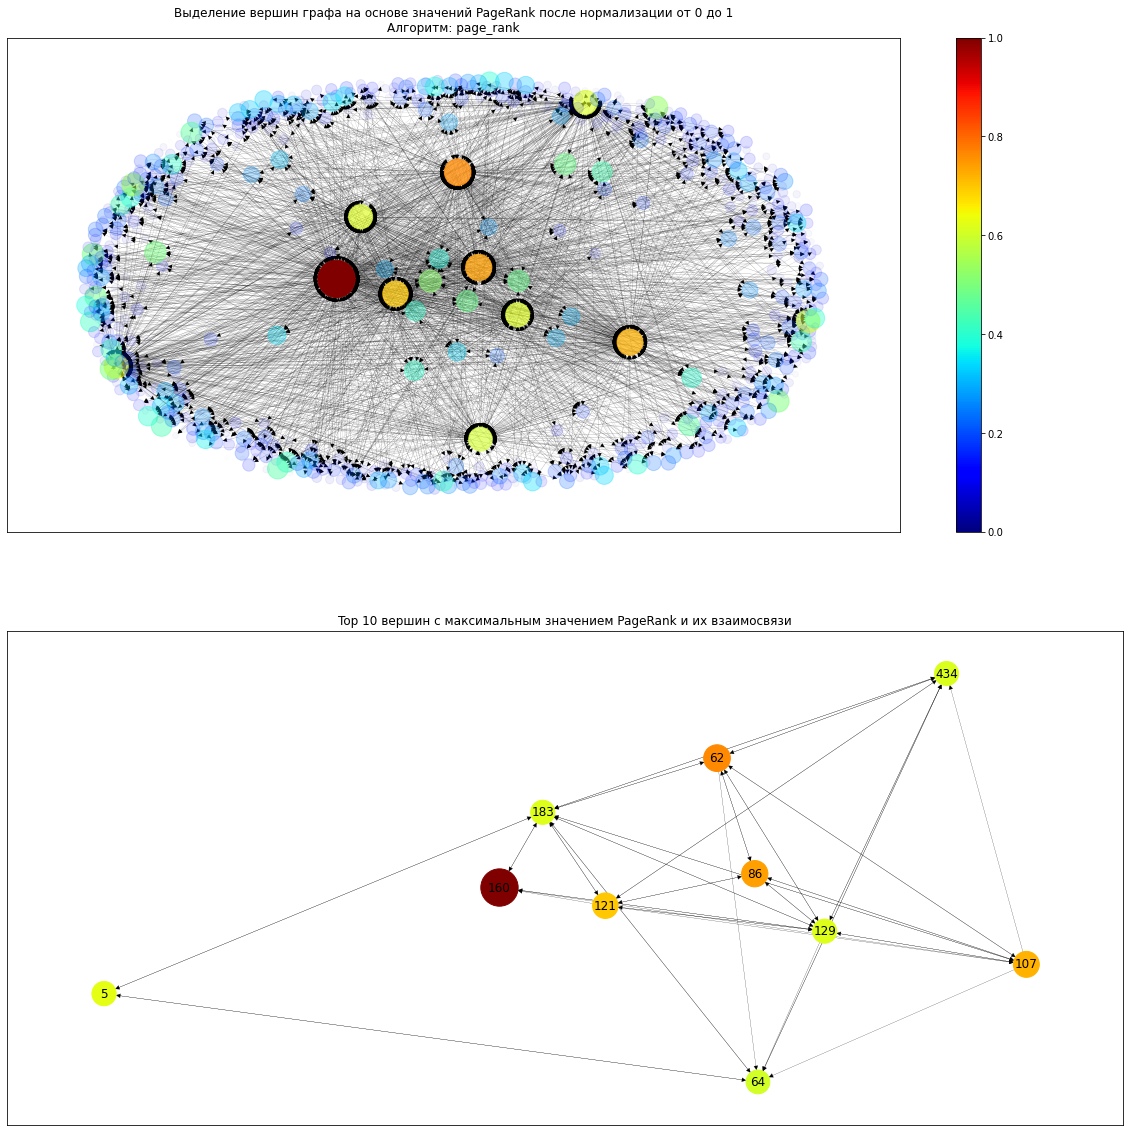

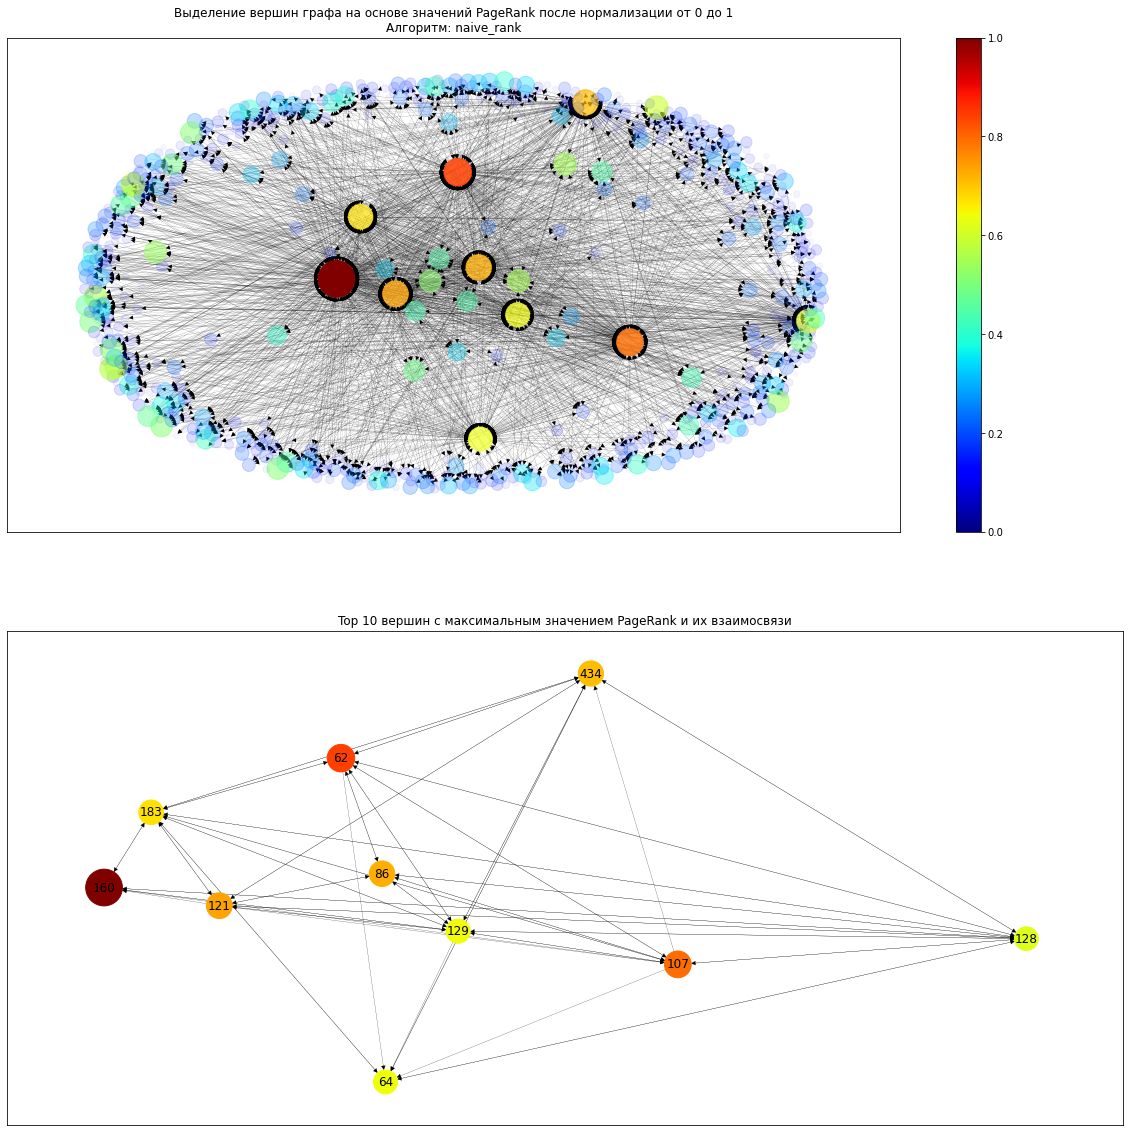

In [11]:
for rank_type in ("page_rank", "naive_rank"):
    fig = plot_rank(subg, layout_pos, rank_data, rank_type)
    fig.savefig(os.path.join("images", f"{rank_type}.png"), dpi=150, pil_kwargs={"optimize": True, "compress_level": 9}, transparent=False)